# Forest Cover Type Classification using Neural Networks
### Delivered by
- Mohamed Abdelmohsen Soliman

## **Required Libraries**

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import tqdm as notebook_tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

### **Libraries versions**

In [208]:
## Libraries version check
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Mediapipe version: {mp.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Pandas version: 2.3.0
Numpy version: 1.26.4
Mediapipe version: 0.10.21
Matplotlib version: 3.10.3
Seaborn version: 0.13.2
OpenCV version: 4.11.0
PyTorch version: 2.2.2
Scikit-learn version: 1.7.0


### As I have searched, to make a model reproducable, we must fix the see of any randomness!

here it is

In [209]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Downloading the Dataset

In [210]:
path = 'Datasets/covtype.csv'
df = pd.read_csv(path)

## Let us visualize the data and see its info

In [211]:
df.head(10)

,2596,51,3,258,0,510,221,232,148,6279,...,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,5
0,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
1,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
2,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
3,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
4,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
5,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
6,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
7,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5
8,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,0,0,0,5
9,2612,201,4,180,51,735,218,243,161,6222,...,0,0,0,0,0,0,0,0,0,5


#### as seen above, the data is downloaded without data but we got the .info file that manually describes the headers. we will manually insert the headers now

In [212]:
quantitative = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

wilderness = [f"Wilderness_Area_{i}" for i in range(1, 5)]
soil = [f"Soil_Type_{i}" for i in range(1, 41)]
columns = quantitative + wilderness + soil + ["Cover_Type"]
df.columns = columns

In [213]:
# Quick check
print(df.columns)
print(df.shape)

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_1',
       'Wilderness_Area_2', 'Wilderness_Area_3', 'Wilderness_Area_4',
       'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4',
       'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8',
       'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12',
       'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16',
       'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20',
       'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24',
       'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28',
       'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32',
       'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36',
       'Soil_Type_37', '

In [214]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
1,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
2,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
3,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
4,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581011 entries, 0 to 581010
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581011 non-null  int64
 1   Aspect                              581011 non-null  int64
 2   Slope                               581011 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581011 non-null  int64
 4   Vertical_Distance_To_Hydrology      581011 non-null  int64
 5   Horizontal_Distance_To_Roadways     581011 non-null  int64
 6   Hillshade_9am                       581011 non-null  int64
 7   Hillshade_Noon                      581011 non-null  int64
 8   Hillshade_3pm                       581011 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581011 non-null  int64
 10  Wilderness_Area_1                   581011 non-null  int64
 11  Wilderness_Area_2                   581011 non-null 

This Dataset is too huge, I will sample a 20% of this Data to train my NN on it

In [216]:
from sklearn.model_selection import train_test_split

df, _ = train_test_split(
    df,
    test_size=0.8,
    stratify=df["Cover_Type"],
    random_state=42
)

### Checking for Nulls

In [217]:
df.isnull().sum().sum()

0

#### there are no nulls in the dataset, so let us proceed and seeing the statistics

In [218]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,...,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000,116202.000000
mean,2959.756657,155.613931,14.120437,269.375854,46.639963,2344.660040,212.090300,223.346423,142.603940,1976.992418,...,0.089628,0.078002,0.002831,0.003244,0.000241,0.000516,0.026153,0.023382,0.015361,2.051454
std,279.799926,111.843701,7.497408,212.422028,58.535989,1555.567796,26.851646,19.731058,38.335512,1319.837377,...,0.285650,0.268176,0.053135,0.056867,0.015521,0.022717,0.159590,0.151113,0.122985,1.396484
min,1872.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2810.000000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1995.000000,218.000000,226.000000,143.000000,1707.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3164.000000,260.000000,18.000000,384.000000,69.000000,3316.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3856.000000,360.000000,61.000000,1397.000000,598.000000,7063.000000,254.000000,254.000000,254.000000,7172.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116202 entries, 340522 to 580228
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           116202 non-null  int64
 1   Aspect                              116202 non-null  int64
 2   Slope                               116202 non-null  int64
 3   Horizontal_Distance_To_Hydrology    116202 non-null  int64
 4   Vertical_Distance_To_Hydrology      116202 non-null  int64
 5   Horizontal_Distance_To_Roadways     116202 non-null  int64
 6   Hillshade_9am                       116202 non-null  int64
 7   Hillshade_Noon                      116202 non-null  int64
 8   Hillshade_3pm                       116202 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  116202 non-null  int64
 10  Wilderness_Area_1                   116202 non-null  int64
 11  Wilderness_Area_2                   116202 non-null 

#### Now we have ~ 110K Rows with 55 features to predict 7 different classes:
- Spruce/Fir - 1
- Lodgepole Pine - 2
- Ponderosa Pine - 3
- Cottonwood/Willow - 4
- Aspen - 5
- Douglas-fir - 6
- Krummholz - 7

but we will need to convert the class label into 0-6 range since categoricalcross entropy expects beginning from zero

In [220]:
df["Cover_Type"] = df["Cover_Type"] - 1

#### Now they are
- Spruce/Fir - 0
- Lodgepole Pine - 1
- Ponderosa Pine - 2
- Cottonwood/Willow - 3
- Aspen - 4
- Douglas-fir - 5
- Krummholz - 6

Quick Check

In [221]:
print("Class label ranges are from ", df["Cover_Type"].min(), ' to ', df["Cover_Type"].max())

Class label ranges are from  0  to  6


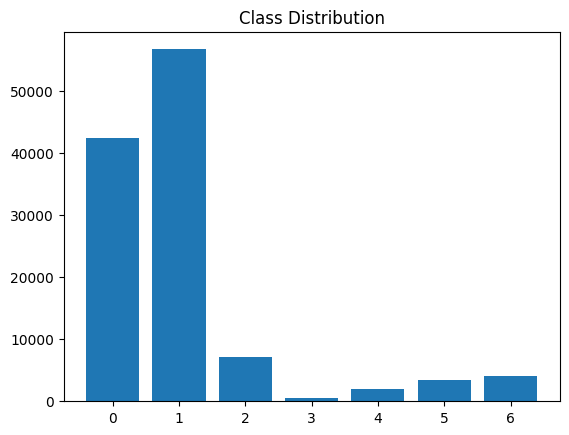

In [222]:
classesCount = df["Cover_Type"].value_counts().sort_index()
ClassLabels = classesCount.index
fig, ax = plt.subplots()
ax.bar(ClassLabels,classesCount)
plt.title("Class Distribution")
plt.show()

In [223]:
class_counts = df["Cover_Type"].value_counts().sort_index()
print(class_counts)

Cover_Type
0    42368
1    56660
2     7151
3      550
4     1898
5     3473
6     4102
Name: count, dtype: int64


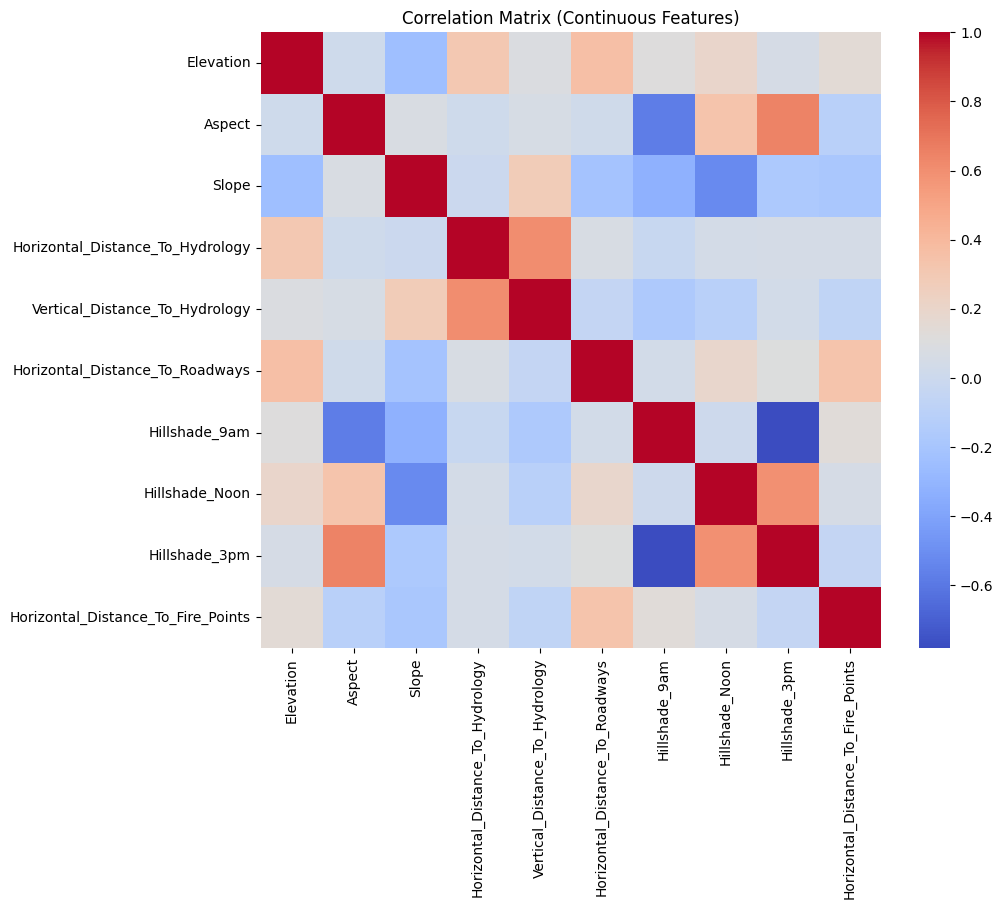

In [224]:
plt.figure(figsize=(10,8))
sns.heatmap(df.iloc[:, :10].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix (Continuous Features)")
plt.show()

### Checking for outliers

In [225]:
continuous_cols = df.columns[:10]

outlier_summary = {}

for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = len(outliers)

print(outlier_summary)

{'Elevation': 3135, 'Aspect': 0, 'Slope': 3068, 'Horizontal_Distance_To_Hydrology': 2897, 'Vertical_Distance_To_Hydrology': 6302, 'Horizontal_Distance_To_Roadways': 139, 'Hillshade_9am': 3502, 'Hillshade_Noon': 3119, 'Hillshade_3pm': 1586, 'Horizontal_Distance_To_Fire_Points': 6152}


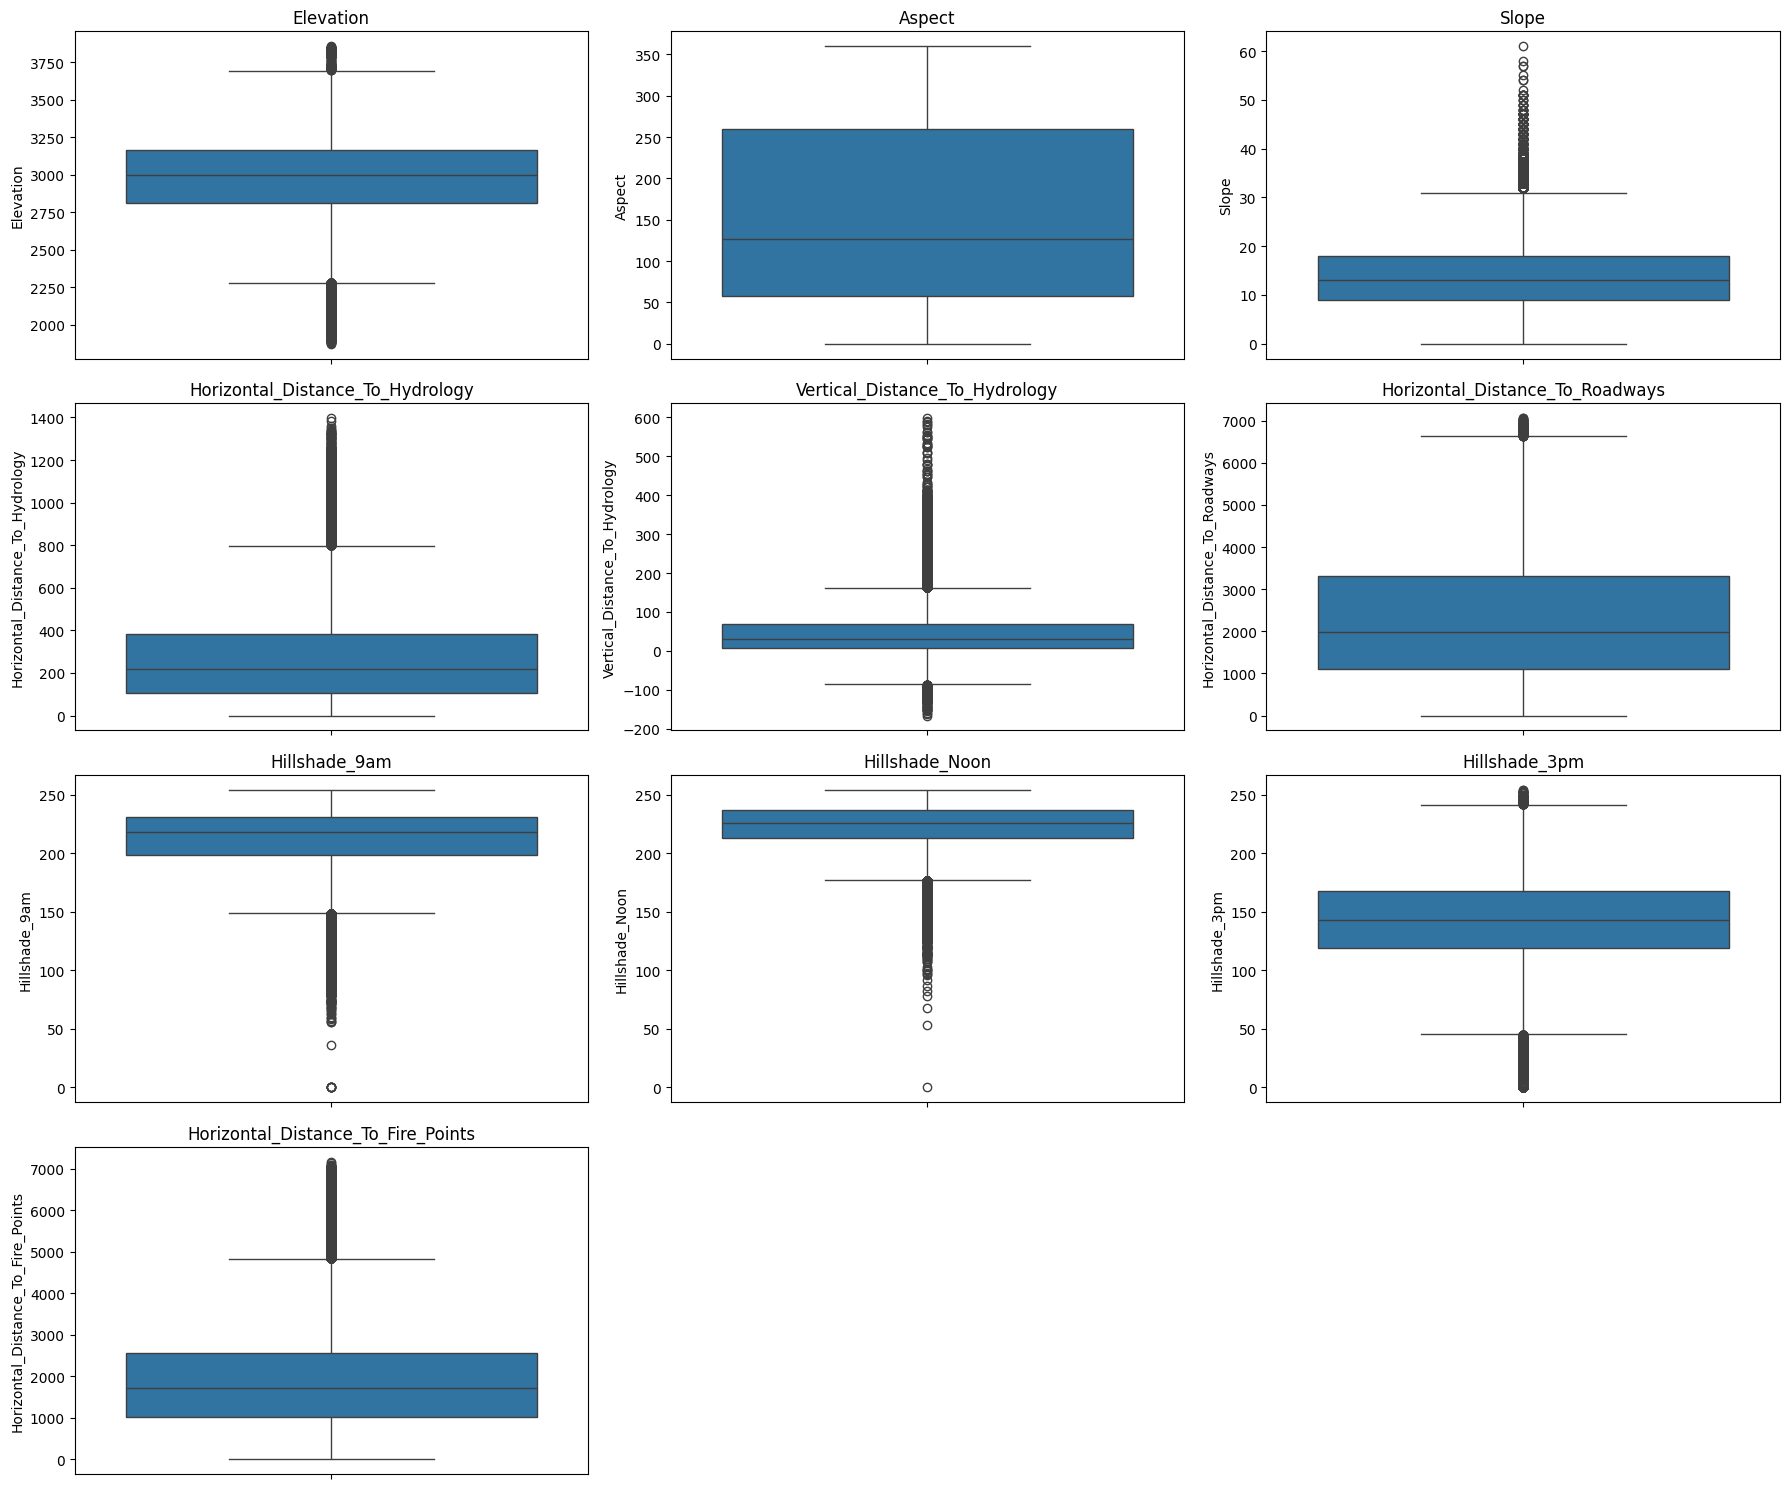

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,15))

for i, col in enumerate(continuous_cols):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### although having some outliers, What i searched for is that covertype is based on true experiments. Therefore, we cannot drop or remove any of those outliers since it will distort real data and the predicted values won't be valid!

However, we can scale the data using StandardScaler from Sklearn

In [227]:
from sklearn.preprocessing import StandardScaler

continuous_cols = df.columns[:10]

df[continuous_cols] = df[continuous_cols].astype(float)
X = df.drop(columns=["Cover_Type"], axis = 1)
Y = df["Cover_Type"]

## Perprocessing & Scaling on teh data after splitting to avoid any data leakage

In [228]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [229]:
X_train, X_val, y_train, y_val = train_test_split(
    X, Y,
    test_size=0.125,
    stratify=y,
    random_state=42
)

In [234]:
X_trainTensors = torch.tensor(X_train.values, dtype=torch.float32)
y_trainTensors = torch.tensor(y_train.values, dtype=torch.long)

X_valTensors = torch.tensor(X_val.values, dtype=torch.float32)
y_valTensors = torch.tensor(y_val.values, dtype=torch.long)

X_testTensors = torch.tensor(X_test.values, dtype=torch.float32)
y_testTensors = torch.tensor(y_test.values, dtype=torch.long)

In [236]:
train_ds = TensorDataset(X_trainTensors, y_trainTensors)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TensorDataset(X_valTensors, y_valTensors)
val_loader = DataLoader(val_ds, batch_size=64)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.Linear(32, num_classes) 
        )
        
    def forward(self, x):
        return self.network(x)

model = SimpleNN(input_size=54, num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

SimpleNN(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [ ]:
class ComplexModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ComplexModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Linear(32, num_classes) 
        )
        
    def forward(self, x):
        return self.network(x)

model2 = ComplexModel(input_size=54, num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
print(model2)

In [252]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [253]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    # here we are initializing lists to append the preds and labels
    all_preds = [] 
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, np.array(all_labels), np.array(all_preds)

In [254]:
num_epochs = 80
patience = 20
best_val_loss = float("inf")
best_state = None
epochs_without_improvement = 0

# lists to append all losses and metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train() # model trains again in each epoch to update the weights based on the training data
    running_loss = 0.0 # starts with 0 at the beginning of each epoch to accumulate the loss over the batches
    train_preds = []
    train_labels = []

    for xb, yb in train_loader: # iterate through the training data in batches
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad() 
        logits = model(xb)# forward pass to get the predicted logits for the current batch
        loss = criterion(logits, yb) # calculate the loss between the predicted logits and the true labels for the current batch
        loss.backward() # backward step
        optimizer.step() # update the model parameters based on the calculated gradients

        running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        # filling the lists
        train_preds.extend(preds.detach().cpu().numpy())
        train_labels.extend(yb.detach().cpu().numpy())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = accuracy_score(train_labels, train_preds)

    epoch_val_loss, epoch_val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    print(
        f"Epoch [{epoch+1:02d}/{num_epochs}] | "
        f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}"
    )

    if epoch_val_loss < best_val_loss: # this is an if condition to use early stopping.
        best_val_loss = epoch_val_loss
        best_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience: # if th threshold is reached, training is stopped!
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch [01/80] | Train Loss: 1.1286 | Train Acc: 0.5807 | Val Loss: 0.7815 | Val Acc: 0.6580
Epoch [02/80] | Train Loss: 0.7542 | Train Acc: 0.6719 | Val Loss: 0.7347 | Val Acc: 0.6925
Epoch [03/80] | Train Loss: 0.7238 | Train Acc: 0.6877 | Val Loss: 0.7076 | Val Acc: 0.6908
Epoch [04/80] | Train Loss: 0.6989 | Train Acc: 0.6988 | Val Loss: 0.6703 | Val Acc: 0.7075
Epoch [05/80] | Train Loss: 0.6839 | Train Acc: 0.7057 | Val Loss: 0.7049 | Val Acc: 0.6977
Epoch [06/80] | Train Loss: 0.6685 | Train Acc: 0.7137 | Val Loss: 0.6432 | Val Acc: 0.7275
Epoch [07/80] | Train Loss: 0.6539 | Train Acc: 0.7173 | Val Loss: 0.6337 | Val Acc: 0.7334
Epoch [08/80] | Train Loss: 0.6412 | Train Acc: 0.7230 | Val Loss: 0.6089 | Val Acc: 0.7417
Epoch [09/80] | Train Loss: 0.6306 | Train Acc: 0.7277 | Val Loss: 0.6207 | Val Acc: 0.7307
Epoch [10/80] | Train Loss: 0.6264 | Train Acc: 0.7298 | Val Loss: 0.6248 | Val Acc: 0.7278
Epoch [11/80] | Train Loss: 0.6165 | Train Acc: 0.7337 | Val Loss: 0.6315 | Val 

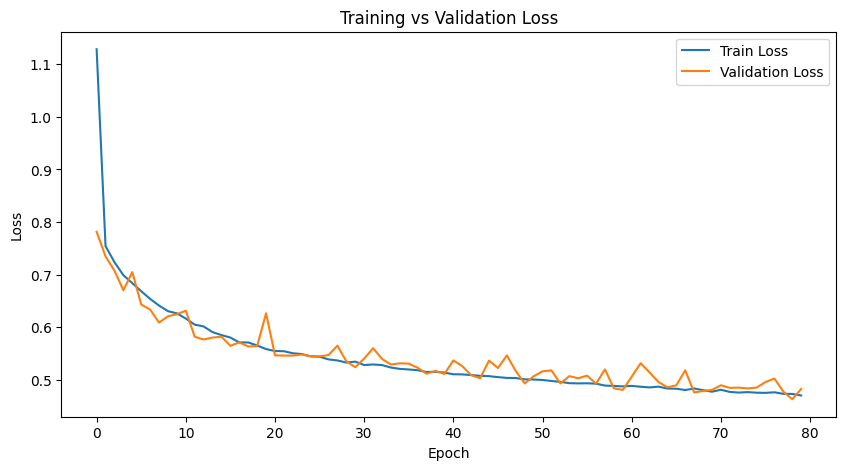

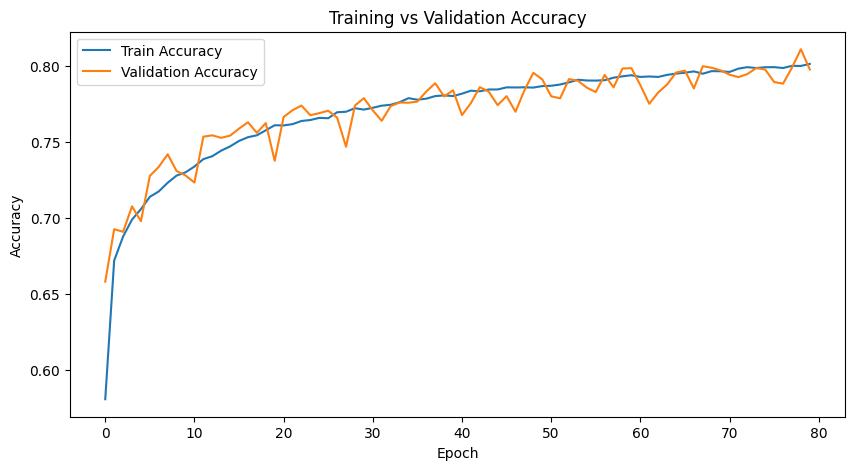

In [255]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()